# t-distributed Stochastic Neighbor Embedding

Getting embeddings in lower dimension.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # Add My Drive/<>

import os
os.chdir('drive/My Drive')
os.chdir('Books_Writings/NLPBook/')

Mounted at /content/drive


In [ ]:
%%capture
%pylab inline
import pandas as pd
import os
%load_ext rpy2.ipython

## t-SNE Plots

Here is the original t-SNE paper: https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

Properties:

1. t-SNE is slow as the dataset gets large.
2. Distances within cluster are correct but not between cluster so it is not a clustering algorithm, it is a visualization algorithm.
3. You can use it to project down a dataset into 2 or 3 dimensions. If you get separate groups, it suggests that a multiclass classifier may do a good job. See: https://colah.github.io/posts/2014-10-Visualizing-MNIST/

SNE stands for "Stochastic Neighbor Embedding".

## t-SNE Algorithm

The basics of the algorithm are as follows, using the equations in the paper:

1. Get a Gaussian measure of similarity of two points, represented by vectors $x_i$ and $x_j$ as follows:

$$
p_{j|i} = \frac{\exp(-\|x_i-x_j\|^2/2\sigma_i^2)}{\sum_{k \neq i}\exp(-\|x_i-x_k\|^2/2\sigma_i^2)}, \quad p_{j|i} \neq p_{i|j}
$$

2. $x$ is in the high-dimensional space and we are projecting into points $y_i$ and $y_j$ in the low-dimension space, so we can define a similarity metric for the low-dimension space as well. We note that the variance chosen for the low-dimension enbedding is $1/\sqrt{2}$.

$$
q_{j|i} = \frac{\exp(-\|y_i-y_j\|^2)}{\sum_{k \neq i}\exp(-\|y_i-y_k\|^2)}, \quad q_{i|i}=0
$$

3. We want the distributions $p$ and $q$ to be as close as possible, and we define the distance between the two using the [Kullback-Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence). We call this a "cost" (loss) function and minimize this.

$$
C = \sum_i KL(P_i \| Q_i) = \sum_i \sum_j p_{j|i} \log\frac{p_{j|i}}{q_{j|i}}
$$

Here, $P_i$ represents the conditional probability distribution over all other datapoints given datapoint $x_i$, and $Q_i$ represents the conditional probability distribution over all other map points given
map point $y_i$.

4. How to set the parameter $\sigma_i$? This is done by choosing a desired perplexity parameter and setting it equal to

$$
Perp(P_i) = 2^{H(P_i)}, \quad H(P_i) = -\sum_j p_{j|i} log_2 p_{j|i}
$$

where $H(P_i)$ is Shannon entropy.

5. Finally, minimize the loss function by taking derivatives wrt points $y$:

$$
\frac{\partial C}{\partial y_i} = 2 \sum_j [p_{j|i}-q_{j|i}+p_{i|j}-q_{i|j}](y_i-y_j)
$$

This is the dimension of $y_i$.

Let's see the t-SNE plot on the Reuters news dataset.

In [ ]:
## Change Python version if needed
# !sudo apt-get install python3.9
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 2
!python --version

Python 3.11.11


In [ ]:
# Read in text cleaning functions
import nltk
nltk.download('punkt_tab')

# Remove punctuations
import string
def removePuncStr(s):
    for c in string.punctuation:
        s = s.replace(c," ")
    return s

def removePunc(text_array):
    return [removePuncStr(h) for h in text_array]

# Remove numbers
def removeNumbersStr(s):
    for c in range(10):
        n = str(c)
        s = s.replace(n," ")
    return s

def removeNumbers(text_array):
    return [removeNumbersStr(h) for h in text_array]

# Stemming
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

def stemText(text_array):
    stemmed_text = []
    for h in text_array:
        words = word_tokenize(h)
        h2 = ''
        for w in words:
            h2 = h2 + ' ' + PorterStemmer().stem(w)
        stemmed_text.append(h2)
    return stemmed_text

# Remove Stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def stopText(text_array):
    stop_words = set(stopwords.words('english'))
    stopped_text = []
    for h in text_array:
        words = word_tokenize(h)
        h2 = ''
        for w in words:
            if w not in stop_words:
                h2 = h2 + ' ' + w
        stopped_text.append(h2)
    return stopped_text

# Write all docs to separate files
def write2textfile(s,filename):
    text_file = open(filename, "w")
    text_file.write(s)
    text_file.close()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
%%time
import nltk
from nltk.corpus import PlaintextCorpusReader
corpus_root = 'NLP_data/reuters/training/'
ctext = PlaintextCorpusReader(corpus_root, '.*')

CPU times: user 120 ms, sys: 20.6 ms, total: 140 ms
Wall time: 25.4 s


In [ ]:
%%time
#Convert corpus to text array with a full string for each doc
def merge_arrays(word_lists):
    wordlist = []
    for wl in word_lists:
        wordlist = wordlist + wl
    doc = ' '.join(wordlist)
    return doc

nltk.download('punkt')
#Run this through the corpus to get a word array for each doc
text_array = []
for p in ctext.paras():
    doc = merge_arrays(p)
    text_array.append(doc)

#Clean up the docs using the previous functions
news = text_array
news = removePunc(news)
news = removeNumbers(news)
news = stopText(news)
#news = stemText(news)
news = [j.lower() for j in news]

df = pd.DataFrame(news, columns=["Text"])
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


CPU times: user 12.8 s, sys: 2.08 s, total: 14.9 s
Wall time: 6min 3s


Text
0   bahia cocoa review showers continued througho...
1   computer terminal systems lt cpml completes s...
2   n z trading bank deposit growth rises slightl...
3   national amusements again ups viacom lt via b...
4   rogers lt rog sees st qtr net up significantl...

In [ ]:
#Create plain DTM
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

docs = news
vec = TfidfVectorizer(min_df=0.01, max_df=0.9)
X = vec.fit_transform(docs)
dtm = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())
print(dtm.shape)
dtm

(8471, 953)


able  accepted  accord  according   account  accounting  accounts  \
0      0.0       0.0     0.0        0.0  0.000000         0.0       0.0   
1      0.0       0.0     0.0        0.0  0.000000         0.0       0.0   
2      0.0       0.0     0.0        0.0  0.000000         0.0       0.0   
3      0.0       0.0     0.0        0.0  0.000000         0.0       0.0   
4      0.0       0.0     0.0        0.0  0.000000         0.0       0.0   
...    ...       ...     ...        ...       ...         ...       ...   
8466   0.0       0.0     0.0        0.0  0.181656         0.0       0.0   
8467   0.0       0.0     0.0        0.0  0.000000         0.0       0.0   
8468   0.0       0.0     0.0        0.0  0.000000         0.0       0.0   
8469   0.0       0.0     0.0        0.0  0.000000         0.0       0.0   
8470   0.0       0.0     0.0        0.0  0.000000         0.0       0.0   

       acquire  acquired  acquisition  ...  working  world  worth     would  \
0     0.000000       0.0          0.0  ...      0.0    0.0    0.0  0.026586   
1     0.072832       0.0          0.0  ...      0.0    0.0    0.0  0.138419   
2     0.000000       0.0          0.0  ...      0.0    0.0    0.0  0.000000   
3     0.000000       0.0          0.0  ...      0.0    0.0    0.0  0.000000   
4     0.000000       0.0          0.0  ...      0.0    0.0    0.0  0.000000   
...        ...       ...          ...  ...      ...    ...    ...       ...   
8466  0.000000       0.0          0.0  ...      0.0    0.0    0.0  0.000000   
8467  0.000000       0.0          0.0  ...      0.0    0.0    0.0  0.000000   
8468  0.000000       0.0          0.0  ...      0.0    0.0    0.0  0.000000   
8469  0.000000       0.0          0.0  ...      0.0    0.0    0.0  0.000000   
8470  0.000000       0.0          0.0  ...      0.0    0.0    0.0  0.000000   

          year     years  yen  yesterday  yet      york  
0     0.040825  0.000000  0.0   0.000000  0.0  0.352282  
1     0.000000  0.066417  0.0   0.000000  0.0  0.000000  
2     0.218928  0.000000  0.0   0.000000  0.0  0.000000  
3     0.000000  0.000000  0.0   0.100464  0.0  0.000000  
4     0.127352  0.000000  0.0   0.000000  0.0  0.000000  
...        ...       ...  ...        ...  ...       ...  
8466  0.000000  0.000000  0.0   0.000000  0.0  0.000000  
8467  0.000000  0.000000  0.0   0.000000  0.0  0.000000  
8468  0.000000  0.000000  0.0   0.000000  0.0  0.000000  
8469  0.055422  0.000000  0.0   0.000000  0.0  0.000000  
8470  0.126124  0.000000  0.0   0.000000  0.0  0.000000  

[8471 rows x 953 columns]

## Illustrating t-SNE

We use the texthero library here: https://spacy.io/universe/project/texthero




In [ ]:
!pip install -U gensim --quiet

In [ ]:
import random
news_sample = random.sample(list(df.Text),100)
news_sample

[' u s weekly soybean crush bushels reporting members national soybean processors association nspa crushed bushels soybeans week ended feb compared bushels previous week year ago week association said it said total crushing capacity members bushels vs last week bushels last year nspa also said u s soybean meal exports week tonnes vs tonnes week ago compared tonnes year ago week nspa said figures include nspa member firms',
 ' claremont tells sec it seeks pct champion products stake two board seats',
 ' uk average gdp rises preliminary pct in up pct in th qtr official',
 ' api says distillate stocks off mln bbls gasoline off mln crude up mln',
 ' norsk hydro saga seek drilling rights in gabon norwegian oil companies norsk hydro a s lt nhy ol saga petroleum a s lt sago ol said applied offshore exploration drilling licenses gabon africa west coast saga petroleum said applied pct share operatorship one block adding finnish oil company neste lt neoy he pct spain hispanoil pct world bank int

In [ ]:
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#Tokenize each document
def textTokenize(text_array):
    textTokens = []
    for h in text_array:
        textTokens.append(h.split(' '))
    return textTokens

sentences = textTokenize(news_sample)

#Train the model on Word2Vec
model = gensim.models.Word2Vec(sentences, min_count=1)

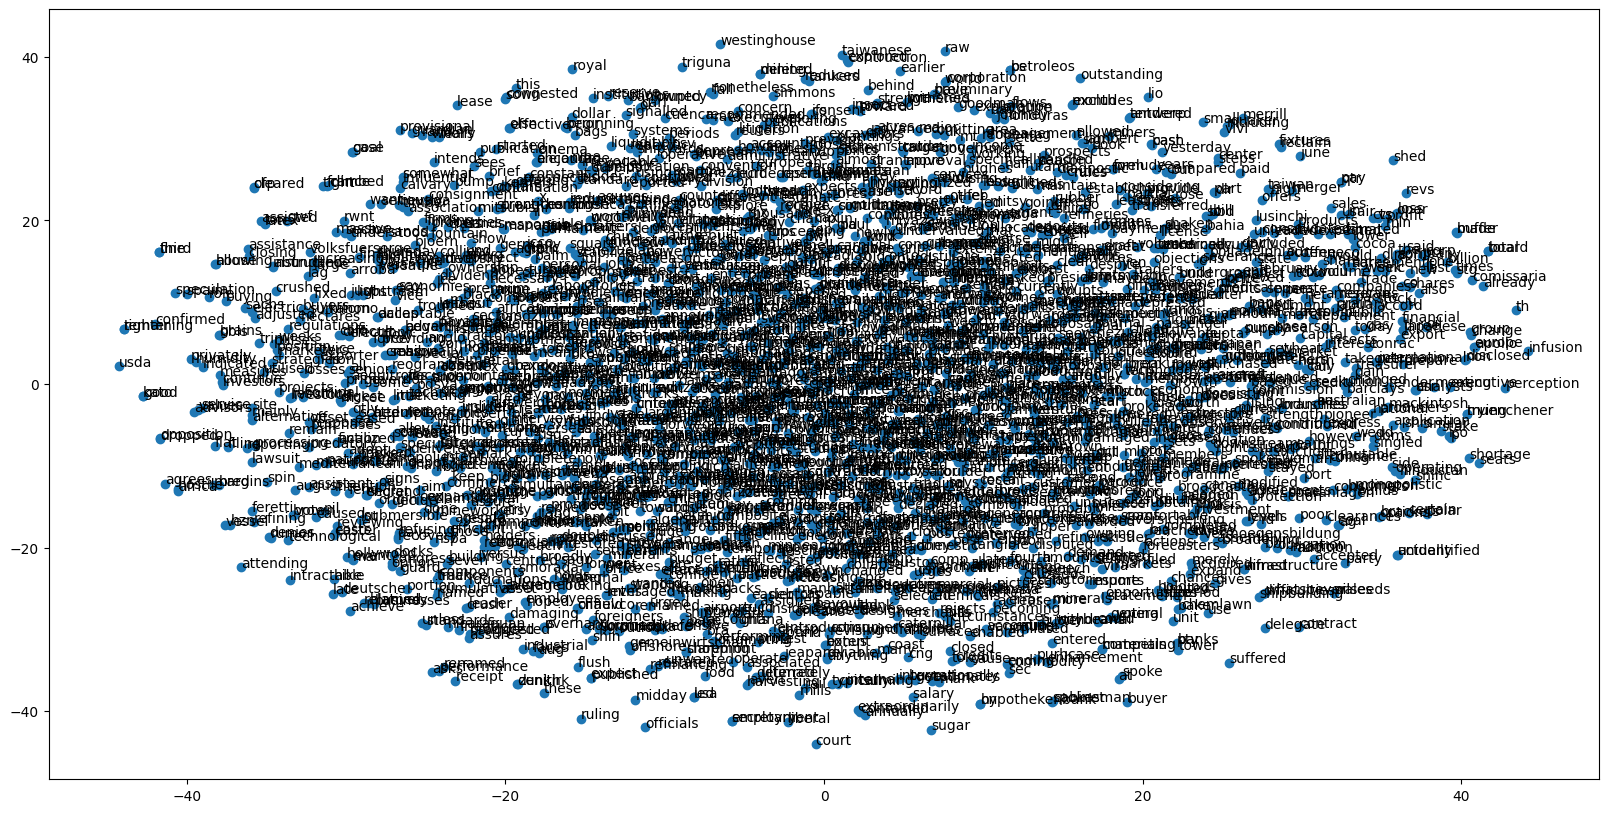

In [ ]:
%%time
from sklearn.manifold import TSNE

# X = model.wv[model.wv.key_to_index]
# labels = model.wv.index_to_key

X = model.wv.vectors
labels = model.wv.index_to_key

figure(figsize=(20,10))

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
x = X_tsne[:, 0]
y = X_tsne[:, 1]

scatter(x,y)
for i, txt in enumerate(labels):
    annotate(txt, (x[i], y[i]))
show()

## UMAP

Recently, there is an improvement on t-SNE, called UMAP, coming from the Biology and Life Sciences, see: https://arxiv.org/abs/1802.03426

UMAP extends to any dimensional enbedding, replaces the perplexity requirement with a nearest-neighbors one (see the top of page 15 here: https://arxiv.org/pdf/1802.03426.pdf, and is faster in run time.

## Let's use TextHero

https://texthero.org/

TextHero's text cleaning function does the following cleanups:

1. Fills in empty space for `na` values
2. lowercase text
3. removes digits
4. removes punctuation
5. remove stopwords
6. removes whitespace
7. removes accents on words (also known as "diacritics")

In [ ]:
# !pip install unidecode
# !pip install gensim==4.2.0
# !pip install texthero==1.0.4

CPU times: user 36.2 s, sys: 390 ms, total: 36.5 s
Wall time: 52.2 s


Sadly, `texthero` has not been maintained or updated since 2021, and has many conflicts with other active libraries, in particular `pandas`. The installs above may be useful but need a lot of work to get working, so I have deprecated it for now in these notes.